In [5]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
from torchvision import models
import matplotlib.pyplot as plt
import utils

In [7]:
from utils.models.transforms import augmentation_transform_2d, calculate_edge_mean_2d
from PIL import Image

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False):
        
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'control']
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathways_folder[pathway_label])
            for i in os.listdir(pathway_dir):
                image_path = os.path.join(pathway_dir, i)
                image = Image.open(image_path)
                image = np.array(image)
                self.data.append((image, pathway_label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx][0], self.data[idx][1]
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1)
        
        # Apply any prebuilt transforms (if provided)
        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        if self.augmentation:
            # --- Cut Augmentation (Cutout) Implementation ---
            # Get image dimensions (C, H, W)
            _, H, W = image_tensor.shape

            # Determine cutout size: a random square size between 10% and 30% of the smaller image dimension.
            min_dim = min(H, W)
            cutout_size = np.random.randint(int(0.1 * min_dim), int(0.3 * min_dim) + 1)

            # Choose a random position so that the square fits within the image.
            top = np.random.randint(0, H - cutout_size + 1)
            left = np.random.randint(0, W - cutout_size + 1)

            # Set the selected region to black (pixel value 0).
            image_tensor[:, top:top+cutout_size, left:left+cutout_size] = 0
            # --------------------------------------------------
        
        return image_tensor, label

In [ ]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=False)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [ ]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 42,508,356
Trainable Parameters: 14,972,932


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [ ]:
import utils
utils.models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, save_model=False, save_name='2D_MIP')

  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

Epoch : 0
train loss : 0.020624 || train_acc : 0.5534
val loss : 0.280825 || val_acc : 0.2308


  7%|▋         | 2/30 [00:01<00:26,  1.07it/s]

Epoch : 1
train loss : 0.009445 || train_acc : 0.8214
val loss : 0.070710 || val_acc : 0.3590


 10%|█         | 3/30 [00:02<00:22,  1.20it/s]

Epoch : 2
train loss : 0.004342 || train_acc : 0.9782
val loss : 0.003404 || val_acc : 0.9744


 13%|█▎        | 4/30 [00:03<00:19,  1.30it/s]

Epoch : 3
train loss : 0.002484 || train_acc : 0.9826
val loss : 0.001502 || val_acc : 1.0000


 17%|█▋        | 5/30 [00:04<00:18,  1.34it/s]

Epoch : 4
train loss : 0.001397 || train_acc : 1.0000
val loss : 0.001489 || val_acc : 1.0000


 20%|██        | 6/30 [00:04<00:17,  1.38it/s]

Epoch : 5
train loss : 0.000758 || train_acc : 1.0000
val loss : 0.001517 || val_acc : 0.9744


 23%|██▎       | 7/30 [00:05<00:16,  1.40it/s]

Epoch : 6
train loss : 0.000485 || train_acc : 1.0000
val loss : 0.000788 || val_acc : 1.0000


 27%|██▋       | 8/30 [00:06<00:15,  1.43it/s]

Epoch : 7
train loss : 0.000364 || train_acc : 1.0000
val loss : 0.000635 || val_acc : 1.0000


 30%|███       | 9/30 [00:06<00:14,  1.43it/s]

Epoch : 8
train loss : 0.000255 || train_acc : 1.0000
val loss : 0.000619 || val_acc : 1.0000


 33%|███▎      | 10/30 [00:07<00:13,  1.43it/s]

Epoch : 9
train loss : 0.000179 || train_acc : 1.0000
val loss : 0.000577 || val_acc : 1.0000


 37%|███▋      | 11/30 [00:08<00:13,  1.45it/s]

Epoch : 10
train loss : 0.000140 || train_acc : 1.0000
val loss : 0.000496 || val_acc : 1.0000


 40%|████      | 12/30 [00:08<00:12,  1.45it/s]

Epoch : 11
train loss : 0.000118 || train_acc : 1.0000
val loss : 0.000454 || val_acc : 1.0000


 43%|████▎     | 13/30 [00:09<00:11,  1.45it/s]

Epoch : 12
train loss : 0.000104 || train_acc : 1.0000
val loss : 0.000413 || val_acc : 1.0000


 47%|████▋     | 14/30 [00:10<00:11,  1.45it/s]

Epoch : 13
train loss : 0.000083 || train_acc : 1.0000
val loss : 0.000401 || val_acc : 1.0000


 50%|█████     | 15/30 [00:10<00:10,  1.43it/s]

Epoch : 14
train loss : 0.000079 || train_acc : 1.0000
val loss : 0.000387 || val_acc : 1.0000


 53%|█████▎    | 16/30 [00:11<00:10,  1.36it/s]

Epoch : 15
train loss : 0.000064 || train_acc : 1.0000
val loss : 0.000382 || val_acc : 1.0000


KeyboardInterrupt: 

In [17]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

#validation
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images, labels
                
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        val_correct += (preds==labels).sum().item()
        val_total += len(labels)
    
print(f"val_acc : {val_correct/val_total:.4f}")

C:\Users\김민욱\AppData\Local\Temp\ipykernel_28556\424517354.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_

val_acc : 0.8490


<h1> Single image classification </h1>

In [18]:
from PIL import Image
import torch
from torchvision import models
import numpy as np

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
image = Image.open(r"C:\rkka_Projects\cell_death_v2\Data\model_training_08h\mip\train\0_Apoptosis\230510.HeLa_CD95 (35)_patch_2_t_16.png").convert('L')
image = np.array(image)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.unsqueeze(0).repeat(3,1,1)
image_tensor = transform(image_tensor)

In [19]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

#validation
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
with torch.no_grad():
    outputs = model(image_tensor.unsqueeze(0))
    _, preds = torch.max(outputs, 1)

outputs

C:\Users\김민욱\AppData\Local\Temp\ipykernel_24152\3383562444.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death

tensor([[ 2.5578, -4.1902, -5.9299, -1.1236]])

C:\Users\김민욱\AppData\Local\Temp\ipykernel_21960\1550319596.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_deat

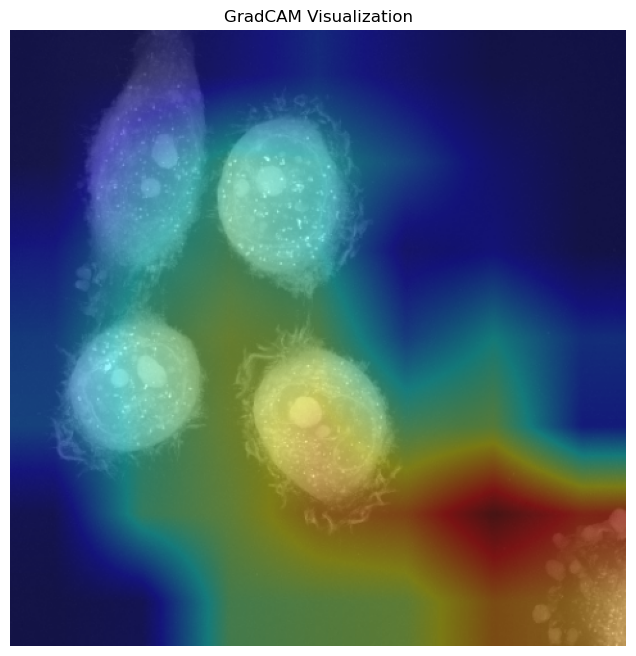

In [19]:
import torch
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimized GradCAM class with minimal hook overhead
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)
        
    def save_activation(self, module, input, output):
        self.activations = output.detach()
        
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
        
    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        score = output[0, class_idx]
        score.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam

# Load and preprocess the image directly with PIL and torchvision transforms
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
img_path = r"C:\rkka_Projects\cell_death_v2\Data\model_training_08h\mip\train\0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P03_patch_3_t_16.png"
original_image = Image.open(img_path).convert('L')
image = np.array(original_image)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.unsqueeze(0).repeat(3,1,1)
image_tensor = transform(image_tensor)

# Load your model and send it to device
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth", map_location=device))
model = model.to(device)
model.eval()

# Use the last conv layer of ResNet101 as the target
target_layer = model.layer4[-1].conv3
gradcam = GradCAM(model, target_layer)

# Generate the heatmap for the input image
heatmap = gradcam(image_tensor.cuda().unsqueeze(0))

# Resize heatmap to match original image dimensions
heatmap = cv2.resize(heatmap, (original_image.width, original_image.height))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert original image to OpenCV format (BGR) for blending
original_cv = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
overlay = cv2.addWeighted(original_cv, 0.6, heatmap_color, 0.4, 0)

# Convert overlay to RGB for matplotlib display
overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

# Visualize the result with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(overlay_rgb)
plt.title('GradCAM Visualization')
plt.axis('off')
plt.show()


<h1> Multi images classification </h1>

In [4]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

#validation
model.eval()
val_loss, val_correct, val_total = 0, 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images, labels
                
        outputs = model(images)

        _, preds = torch.max(outputs, 1)
        val_correct += (preds==labels).sum().item()
        val_total += len(labels)
    
print(f"val_acc : {val_correct/val_total:.4f}")

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_15268\424517354.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

val_acc : 0.6438


In [4]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Parameters: 42,508,356
Trainable Parameters: 14,972,932


In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [6]:
import utils
utils.models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, save_model=False, save_name='2D_MIP')

  3%|▎         | 1/30 [00:01<00:36,  1.26s/it]

Epoch : 0
train loss : 0.020624 || train_acc : 0.5534
val loss : 0.280825 || val_acc : 0.2308


  7%|▋         | 2/30 [00:01<00:26,  1.07it/s]

Epoch : 1
train loss : 0.009445 || train_acc : 0.8214
val loss : 0.070710 || val_acc : 0.3590


 10%|█         | 3/30 [00:02<00:22,  1.20it/s]

Epoch : 2
train loss : 0.004342 || train_acc : 0.9782
val loss : 0.003404 || val_acc : 0.9744


 13%|█▎        | 4/30 [00:03<00:19,  1.30it/s]

Epoch : 3
train loss : 0.002484 || train_acc : 0.9826
val loss : 0.001502 || val_acc : 1.0000


 17%|█▋        | 5/30 [00:04<00:18,  1.34it/s]

Epoch : 4
train loss : 0.001397 || train_acc : 1.0000
val loss : 0.001489 || val_acc : 1.0000


 20%|██        | 6/30 [00:04<00:17,  1.38it/s]

Epoch : 5
train loss : 0.000758 || train_acc : 1.0000
val loss : 0.001517 || val_acc : 0.9744


 23%|██▎       | 7/30 [00:05<00:16,  1.40it/s]

Epoch : 6
train loss : 0.000485 || train_acc : 1.0000
val loss : 0.000788 || val_acc : 1.0000


 27%|██▋       | 8/30 [00:06<00:15,  1.43it/s]

Epoch : 7
train loss : 0.000364 || train_acc : 1.0000
val loss : 0.000635 || val_acc : 1.0000


 30%|███       | 9/30 [00:06<00:14,  1.43it/s]

Epoch : 8
train loss : 0.000255 || train_acc : 1.0000
val loss : 0.000619 || val_acc : 1.0000


 33%|███▎      | 10/30 [00:07<00:13,  1.43it/s]

Epoch : 9
train loss : 0.000179 || train_acc : 1.0000
val loss : 0.000577 || val_acc : 1.0000


 37%|███▋      | 11/30 [00:08<00:13,  1.45it/s]

Epoch : 10
train loss : 0.000140 || train_acc : 1.0000
val loss : 0.000496 || val_acc : 1.0000


 40%|████      | 12/30 [00:08<00:12,  1.45it/s]

Epoch : 11
train loss : 0.000118 || train_acc : 1.0000
val loss : 0.000454 || val_acc : 1.0000


 43%|████▎     | 13/30 [00:09<00:11,  1.45it/s]

Epoch : 12
train loss : 0.000104 || train_acc : 1.0000
val loss : 0.000413 || val_acc : 1.0000


 47%|████▋     | 14/30 [00:10<00:11,  1.45it/s]

Epoch : 13
train loss : 0.000083 || train_acc : 1.0000
val loss : 0.000401 || val_acc : 1.0000


 50%|█████     | 15/30 [00:10<00:10,  1.43it/s]

Epoch : 14
train loss : 0.000079 || train_acc : 1.0000
val loss : 0.000387 || val_acc : 1.0000


 53%|█████▎    | 16/30 [00:11<00:10,  1.36it/s]

Epoch : 15
train loss : 0.000064 || train_acc : 1.0000
val loss : 0.000382 || val_acc : 1.0000


KeyboardInterrupt: 

<h1> Prediction </h1>

In [21]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from TCFile import TCFile
from torchvision import models
import matplotlib.pyplot as plt
import utils
from utils.models.transforms import augmentation_transform_2d, calculate_edge_mean_2d
import h5py

class CellDeathH5Dataset(Dataset):
    """
    Loads an h5 file containing time-lapse data for one patch.
    The file is expected to have a dataset 'data' with shape (T, H, W).
    The dataset returns a tensor of shape (3, window_size, H, W) suitable for r3d_18.
    
    Parameters:
      root_dir (str): Directory with the h5 files.
      start_frame (int): Frame index to start the window from.
      window_size (int): Number of consecutive frames to include.
      transform (callable, optional): Optional transform to apply on the tensor.
    """
    def __init__(self, root_dir, start_frame=0, end_frame=10, transform=None, augmentation=False):
        self.root_dir = root_dir
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        
        pathways = ['apoptosis', 'necroptosis', 'necrosis', 'control']
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control']
        for pathway_label, pathway in enumerate(pathways):
            pathway_dir = os.path.join(root_dir, pathways_folder[pathway_label])
            for i in os.listdir(pathway_dir):
                if i.endswith('.h5'):
                    stack_path = os.path.join(pathway_dir, i)
                    stack = h5py.File(stack_path)['data'][:]
                    self.data.append((stack, pathway_label))
        

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx][0]
        label = self.data[idx][1]
        # Slice the predetermined time window from the h5 file.
        data = data[self.start_frame:self.end_frame, :, :]
        
        # Convert to a torch tensor (shape: [T, H, W])
        data_tensor = torch.from_numpy(data).float()
        
        # Rotation with edge mean filling
        if self.augmentation:
            for idx, d in enumerate(data_tensor):
                d = d.unsqueeze(0)
                edge_mean = calculate_edge_mean_2d(d)
                d = augmentation_transform_2d(d)
                d[d==0] = edge_mean
                d = d.squeeze(0)
                data[idx] = d

        # For r3d_18, we need a tensor of shape (C, T, H, W) with 3 channels.
        # Our data is single-channel so we simply repeat it across channels.
        # 1. Add a channel dimension: (1, T, H, W)
        data_tensor = data_tensor.unsqueeze(1)
        # 2. Repeat to get 3 channels: (3, T, H, W)
        data_tensor = data_tensor.repeat(1, 3, 1, 1)
        
        if self.transform:
            data_tensor = self.transform(data_tensor)
        
        # Return the tensor along with some metadata (e.g. file name) for patch averaging later.
        return data_tensor, label


In [22]:
from torchvision.models import video
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper
from torch.utils.data import DataLoader

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training_timelapse/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training_timelapse/test"

start_frame = 0
end_frame = 6

transform = video.R3D_18_Weights.KINETICS400_V1.transforms()
train_dataset = CellDeathH5Dataset(train_dir, start_frame=start_frame, end_frame=end_frame, transform=transform, augmentation=True)
val_dataset = CellDeathH5Dataset(val_dir, start_frame=start_frame, end_frame=end_frame, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [23]:
import utils

model = video.r3d_18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

Total Parameters: 33,168,324
Trainable Parameters: 24,910,852


In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [25]:
import utils
utils.models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, save_model=False, save_name='2D_Video')

  3%|▎         | 1/30 [00:14<06:50, 14.15s/it]

Epoch : 0
train loss : 0.024198 || train_acc : 0.3647
val loss : 0.062647 || val_acc : 0.5412


  7%|▋         | 2/30 [00:27<06:26, 13.81s/it]

Epoch : 1
train loss : 0.016867 || train_acc : 0.5447
val loss : 0.029126 || val_acc : 0.5529


 10%|█         | 3/30 [00:42<06:23, 14.21s/it]

Epoch : 2
train loss : 0.012276 || train_acc : 0.7271
val loss : 0.010931 || val_acc : 0.7412


 13%|█▎        | 4/30 [00:56<06:07, 14.15s/it]

Epoch : 3
train loss : 0.008815 || train_acc : 0.8037
val loss : 0.012507 || val_acc : 0.6706


 17%|█▋        | 5/30 [01:10<05:49, 13.98s/it]

Epoch : 4
train loss : 0.006927 || train_acc : 0.8548
val loss : 0.010471 || val_acc : 0.7294


 20%|██        | 6/30 [01:23<05:31, 13.82s/it]

Epoch : 5
train loss : 0.005560 || train_acc : 0.9141
val loss : 0.010857 || val_acc : 0.6706


 23%|██▎       | 7/30 [01:37<05:15, 13.72s/it]

Epoch : 6
train loss : 0.005151 || train_acc : 0.9187
val loss : 0.011284 || val_acc : 0.6941


 27%|██▋       | 8/30 [01:50<04:58, 13.57s/it]

Epoch : 7
train loss : 0.004412 || train_acc : 0.9361
val loss : 0.011893 || val_acc : 0.7176


 30%|███       | 9/30 [02:03<04:40, 13.37s/it]

Epoch : 8
train loss : 0.003242 || train_acc : 0.9443
val loss : 0.010506 || val_acc : 0.7529


 33%|███▎      | 10/30 [02:16<04:25, 13.28s/it]

Epoch : 9
train loss : 0.002654 || train_acc : 0.9570
val loss : 0.012093 || val_acc : 0.7412


 37%|███▋      | 11/30 [02:29<04:11, 13.26s/it]

Epoch : 10
train loss : 0.001854 || train_acc : 0.9779
val loss : 0.011734 || val_acc : 0.7765


 40%|████      | 12/30 [02:42<03:58, 13.25s/it]

Epoch : 11
train loss : 0.002338 || train_acc : 0.9489
val loss : 0.009245 || val_acc : 0.7882


 43%|████▎     | 13/30 [02:55<03:44, 13.20s/it]

Epoch : 12
train loss : 0.002605 || train_acc : 0.9501
val loss : 0.016612 || val_acc : 0.7294


 47%|████▋     | 14/30 [03:09<03:30, 13.16s/it]

Epoch : 13
train loss : 0.001590 || train_acc : 0.9919
val loss : 0.011877 || val_acc : 0.7647


 50%|█████     | 15/30 [03:22<03:16, 13.12s/it]

Epoch : 14
train loss : 0.001664 || train_acc : 0.9768
val loss : 0.011168 || val_acc : 0.7765


 53%|█████▎    | 16/30 [03:34<03:03, 13.07s/it]

Epoch : 15
train loss : 0.001555 || train_acc : 0.9814
val loss : 0.013508 || val_acc : 0.6941


 57%|█████▋    | 17/30 [03:48<02:49, 13.07s/it]

Epoch : 16
train loss : 0.001580 || train_acc : 0.9837
val loss : 0.024102 || val_acc : 0.6588


 60%|██████    | 18/30 [04:01<02:37, 13.09s/it]

Epoch : 17
train loss : 0.001604 || train_acc : 0.9884
val loss : 0.015064 || val_acc : 0.7294


 63%|██████▎   | 19/30 [04:14<02:24, 13.16s/it]

Epoch : 18
train loss : 0.001037 || train_acc : 0.9942
val loss : 0.013056 || val_acc : 0.7529


 67%|██████▋   | 20/30 [04:28<02:12, 13.26s/it]

Epoch : 19
train loss : 0.001301 || train_acc : 0.9872
val loss : 0.017222 || val_acc : 0.7059


 70%|███████   | 21/30 [04:41<01:59, 13.30s/it]

Epoch : 20
train loss : 0.001064 || train_acc : 0.9907
val loss : 0.014308 || val_acc : 0.7529


 73%|███████▎  | 22/30 [04:54<01:46, 13.32s/it]

Epoch : 21
train loss : 0.001783 || train_acc : 0.9559
val loss : 0.014743 || val_acc : 0.7529


 77%|███████▋  | 23/30 [05:08<01:33, 13.34s/it]

Epoch : 22
train loss : 0.001277 || train_acc : 0.9756
val loss : 0.021170 || val_acc : 0.6235


 80%|████████  | 24/30 [05:21<01:20, 13.36s/it]

Epoch : 23
train loss : 0.006780 || train_acc : 0.8571
val loss : 0.039823 || val_acc : 0.4941


 83%|████████▎ | 25/30 [05:35<01:07, 13.42s/it]

Epoch : 24
train loss : 0.003655 || train_acc : 0.9082
val loss : 0.032769 || val_acc : 0.4471


 87%|████████▋ | 26/30 [05:48<00:54, 13.51s/it]

Epoch : 25
train loss : 0.002449 || train_acc : 0.9686
val loss : 0.051712 || val_acc : 0.5647


 90%|█████████ | 27/30 [06:03<00:41, 13.90s/it]

Epoch : 26
train loss : 0.001365 || train_acc : 0.9895
val loss : 0.030979 || val_acc : 0.6471


 93%|█████████▎| 28/30 [06:18<00:28, 14.12s/it]

Epoch : 27
train loss : 0.000965 || train_acc : 0.9965
val loss : 0.020052 || val_acc : 0.7059


 97%|█████████▋| 29/30 [06:32<00:14, 14.26s/it]

Epoch : 28
train loss : 0.000637 || train_acc : 0.9919
val loss : 0.021400 || val_acc : 0.6118


100%|██████████| 30/30 [06:47<00:00, 13.58s/it]

Epoch : 29
train loss : 0.000547 || train_acc : 0.9942
val loss : 0.018958 || val_acc : 0.6824


In [20]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import video
from utils.models.transforms import augmentation_transform_2d, calculate_edge_mean_2d
from tqdm import tqdm

#############################
# Base Dataset: One patch per sample
#############################
class CellDeathH5Dataset(Dataset):
    """
    Loads an h5 file for one patch.
    Expects each h5 file to have a dataset 'data' with shape (T, H, W).
    Returns a video tensor (after optional augmentation and transforms) and the file_id for grouping.
    
    NOTE: This version returns the tensor in (T, C, H, W) order.
    
    Parameters:
      root_dir (str): Root directory with class sub-folders.
      start_frame (int): Starting frame index.
      end_frame (int): Ending frame index.
      transform (callable, optional): Transform to apply.
      augmentation (bool): Whether to apply custom augmentation.
    """
    def __init__(self, root_dir, start_frame=0, end_frame=10, transform=None, augmentation=False):
        self.root_dir = root_dir
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.transform = transform
        self.augmentation = augmentation
        self.data = []
        
        # Folder names for each class (assumed order):
        pathways_folder = ['0_Apoptosis', '0_Necroptosis', '0_Necrosis', '0_Control']
        
        for label, folder in enumerate(pathways_folder):
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if fname.endswith('.h5'):
                    full_path = os.path.join(folder_path, fname)
                    with h5py.File(full_path, 'r') as f:
                        stack = f['data'][:]  # shape: (T, H, W)
                    # Extract a base file id to group patches (expects "base_patch_*.h5")
                    file_id = fname.split('_patch_')[0] if '_patch_' in fname else os.path.splitext(fname)[0]
                    self.data.append((stack, label, file_id))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        stack, label, file_id = self.data[idx]
        # Select frames [start_frame:end_frame]
        data = stack[self.start_frame:self.end_frame, :, :]  # (T, H, W)
        
        # Convert to torch tensor (float) – shape (T, H, W)
        data_tensor = torch.from_numpy(data).float()
        
        # Apply augmentation frame-by-frame if requested
        if self.augmentation:
            for t in range(data_tensor.shape[0]):
                frame = data_tensor[t]        # (H, W)
                frame_unsq = frame.unsqueeze(0) # (1, H, W)
                edge_mean = calculate_edge_mean_2d(frame_unsq)
                frame_aug = augmentation_transform_2d(frame_unsq)
                frame_aug[frame_aug == 0] = edge_mean
                data_tensor[t] = frame_aug.squeeze(0)
        
        # Prepare for r3d_18:
        #   Add a channel dimension: (T, 1, H, W)
        #   Repeat to get 3 channels: (T, 3, H, W)
        data_tensor = data_tensor.unsqueeze(1).repeat(1, 3, 1, 1)
        
        # Apply transform (which expects input of shape (T, C, H, W)) if provided.
        if self.transform:
            data_tensor = self.transform(data_tensor)
        
        # NOTE: We do NOT permute here; data_tensor remains (T, C, H, W).
        return data_tensor, label, file_id

#############################
# Grouped Dataset: All patches from the same file
#############################
class GroupedCellDeathDataset(Dataset):
    """
    Groups patches by file_id. Each item is:
         (file_id, patches, label)
    where patches is a tensor of shape (Npatches, T, C, H, W)
    and label is a single int.
    """
    def __init__(self, base_dataset):
        self.grouped = {}
        for data_tensor, label, file_id in base_dataset:
            if file_id not in self.grouped:
                self.grouped[file_id] = {'patches': [], 'label': label}
            self.grouped[file_id]['patches'].append(data_tensor)
        # Build list of grouped items
        self.items = []
        for file_id, info in self.grouped.items():
            patches = torch.stack(info['patches'], dim=0)  # (Npatches, T, C, H, W)
            self.items.append((file_id, patches, info['label']))
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        return self.items[idx]  # (file_id, patches, label)

#############################
# Setup Datasets & DataLoaders
#############################
train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training_timelapse/train"
val_dir   = "C:/rkka_Projects/cell_death_v2/Data/model_training_timelapse/test"
start_frame = 0
end_frame = 10

# Use the torchvision video transform for r3d_18 weights.
transform = video.R3D_18_Weights.KINETICS400_V1.transforms()

# Create the base (patch-level) datasets.
base_train_dataset = CellDeathH5Dataset(train_dir, start_frame, end_frame, transform=transform, augmentation=True)
base_val_dataset   = CellDeathH5Dataset(val_dir, start_frame, end_frame, transform=transform, augmentation=False)

# Group patches by file_id.
grouped_train_dataset = GroupedCellDeathDataset(base_train_dataset)
grouped_val_dataset   = GroupedCellDeathDataset(base_val_dataset)

# Because each file may have a variable number of patches, use batch_size=1.
train_loader = DataLoader(grouped_train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(grouped_val_dataset, batch_size=1, shuffle=False)

#############################
# Setup Model
#############################
model = video.r3d_18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
# Freeze parameters except layer4 and fc.
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
model = model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

#############################
# Training Function with Patch-Averaging
#############################
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, save_model=False, save_name='2D_Video'):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Iterate over files (each file is one item from the grouped dataset)
        for file_id, patches, label in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            # patches: shape from DataLoader is (1, Npatches, T, C, H, W).
            # Remove the batch dimension.
            patches = patches.squeeze(0).cuda()  # Now (Npatches, T, C, H, W)
            # IMPORTANT: Permute dimensions to (Npatches, C, T, H, W) for r3d_18.
            patches = patches.permute(0, 2, 1, 3, 4)
            label = label.cuda()  # (1,)
            
            # Forward pass on all patches for this file.
            outputs = model(patches)  # (Npatches, 4)
            # Average patch predictions to obtain file-level output.
            avg_output = outputs.mean(dim=0, keepdim=True)  # (1, 4)
            loss = criterion(avg_output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, preds = torch.max(avg_output, 1)
            train_correct += (preds == label).sum().item()
            train_total += 1
        
        # Validation loop.
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for file_id, patches, label in val_loader:
                patches = patches.squeeze(0).cuda()  # (Npatches, T, C, H, W)
                patches = patches.permute(0, 2, 1, 3, 4)  # -> (Npatches, C, T, H, W)
                label = label.cuda()
                
                outputs = model(patches)
                avg_output = outputs.mean(dim=0, keepdim=True)
                loss = criterion(avg_output, label)
                
                val_loss += loss.item()
                _, preds = torch.max(avg_output, 1)
                val_correct += (preds == label).sum().item()
                val_total += 1
        
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/train_total:.6f} | Train Acc: {train_correct/train_total:.4f}")
        print(f"Val Loss:   {val_loss/val_total:.6f} | Val Acc:   {val_correct/val_total:.4f}")
        
        if save_model:
            torch.save(model.state_dict(), f'epoch_{epoch+1}_{save_name}_val_acc_{val_correct/val_total:.4f}.pth')

#############################
# Start Training
#############################
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, save_model=False, save_name='2D_Video')


Training Epoch 1/30:   0%|          | 0/47 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 3, 3, 7, 7], expected input[4, 10, 3, 112, 112] to have 3 channels, but got 10 channels instead

<h1> Finetuning </h1>

In [26]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/test"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=False)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [29]:
model = models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

C:\Users\김민욱\AppData\Local\Temp\ipykernel_16864\1805157188.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death

Total Parameters: 42,508,356
Trainable Parameters: 14,972,932


In [97]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0009)

model = model.cuda()

In [98]:
import models
models.train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

  3%|▎         | 1/30 [00:12<06:13, 12.88s/it]

Epoch : 0
train loss : 0.000029 || train_acc : 1.0000
val loss : 2.321047 || val_acc : 0.6762


  7%|▋         | 2/30 [00:25<06:01, 12.91s/it]

Epoch : 1
train loss : 0.000044 || train_acc : 1.0000
val loss : 1.684381 || val_acc : 0.6857


 10%|█         | 3/30 [00:38<05:46, 12.84s/it]

Epoch : 2
train loss : 0.000012 || train_acc : 1.0000
val loss : 2.350869 || val_acc : 0.6762


 13%|█▎        | 4/30 [00:50<05:27, 12.59s/it]

Epoch : 3
train loss : 0.000005 || train_acc : 1.0000
val loss : 1.593525 || val_acc : 0.7238


 17%|█▋        | 5/30 [01:02<05:09, 12.39s/it]

Epoch : 4
train loss : 0.000031 || train_acc : 1.0000
val loss : 2.096108 || val_acc : 0.6857


 20%|██        | 6/30 [01:14<04:53, 12.22s/it]

Epoch : 5
train loss : 0.000827 || train_acc : 0.9991
val loss : 2.210617 || val_acc : 0.6762


 20%|██        | 6/30 [01:17<05:10, 12.92s/it]


KeyboardInterrupt: 

<h1> Confusion matrix </h1>

In [30]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/train"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/mip/test"

transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=False)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)

train_loader = DataLoader(dataset=augmented_train_dataset, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, batch_size=64)

In [31]:
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\김민욱\AppData\Local\Temp\ipykernel_16864\330776203.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

<All keys matched successfully>

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

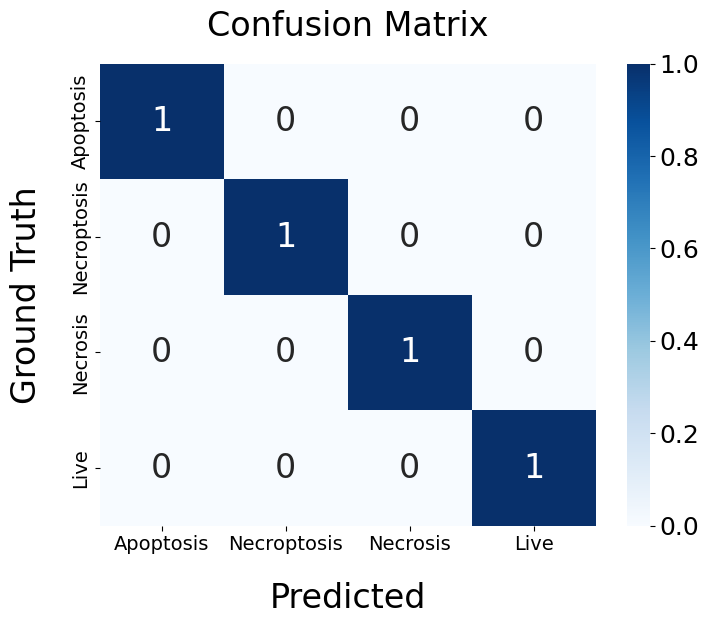

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Apoptosis", "Necroptosis", "Necrosis", "Live"], 
                                          yticklabels=["Apoptosis", "Necroptosis", "Necrosis", "Live"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()

<h1> Timelapse </h1>

In [1]:
import torch
from TCFile import TCFile
import numpy as np
import utils

path = r"C:\rkka_Projects\cell_death_v2\Data\0_Necroptosis\230510.174730.HeLa_Hoechst.001.Group2.A1.T001P20.TCF"
file = TCFile(path, '3D')

stack = []
for f in file:
    slice_2d = utils.resize_tomogram_2d(f, data_resolution=file.data_resolution, target_resolution=0.1632, mode='mip')

    slice_2d = slice_2d[0:480, 0:480]
    slice_2d = utils.image_normalization(slice_2d, min=1.33, max=1.40)
    
    stack.append(slice_2d)

c:\miniconda3\envs\cell\Lib\site-packages\TCFile\TCFile_class.py:190: UserWarning: You use an experimental file format deprecated.
Update your reconstruction program and rebuild TCF file.
  warnings.warn(("You use an experimental file format deprecated.\n"


In [3]:
import torchvision
import torch
model = torchvision.models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_13112\1749555092.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_deat

<All keys matched successfully>

In [ ]:
import torchvision 

model = model.cuda()
model.eval()

min_ri = 1.33
max_ri = 1.40

transform = torchvision.models.ResNet101_Weights.IMAGENET1K_V2.transforms()
transformed_s = []
with torch.no_grad():
    apoptosis_prob = []
    necroptosis_prob = []
    necrosis_prob = []
    live_prob = []
    
    for s in stack:
        N = len(stack)
        death_probability = 0
        output_list = []
        
        s = torch.from_numpy(s).cuda()

        # Step 2 : Make RGB channel - C
        s = s.unsqueeze(0)
        s = s.repeat(3,1,1) # (C, H, W)
        s = transform(s)
        transformed_s.append(s)
 
        output = model(s.unsqueeze(0).cuda())
        output_prob = torch.nn.functional.softmax(output)
        
        apoptosis_prob.append(float(output_prob[0][0].cpu()))
        necroptosis_prob.append(float(output_prob[0][1].cpu()))
        necrosis_prob.append(float(output_prob[0][2].cpu()))
        live_prob.append(float(output_prob[0][3].cpu()))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_13112\4014620853.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_prob = torch.nn.functional.softmax(output)


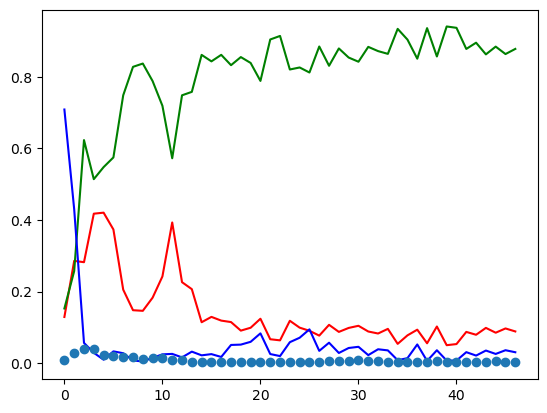

In [8]:
import matplotlib.pyplot as plt

plt.plot(apoptosis_prob, 'r')
plt.plot(necroptosis_prob, 'g')
plt.plot(necrosis_prob, 'b')
plt.plot(live_prob, 'o')

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20396\2735660192.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
C:\Users\김민욱\Ap

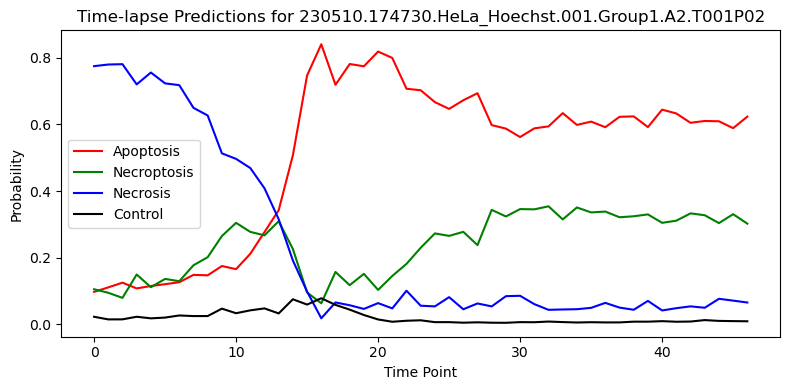

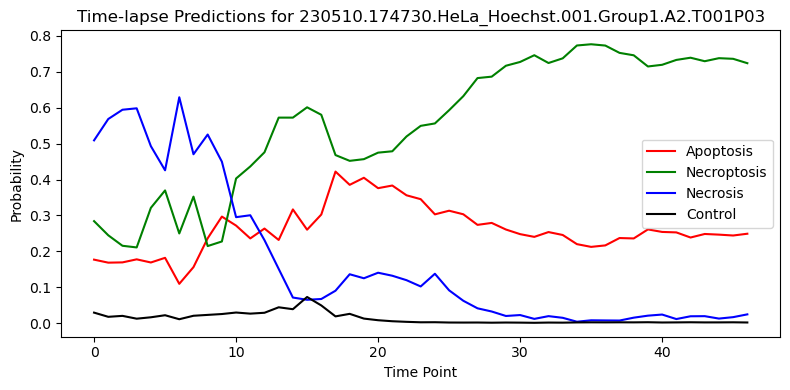

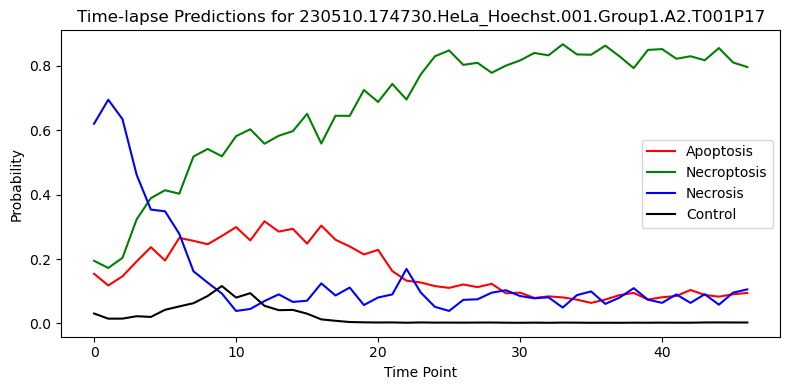

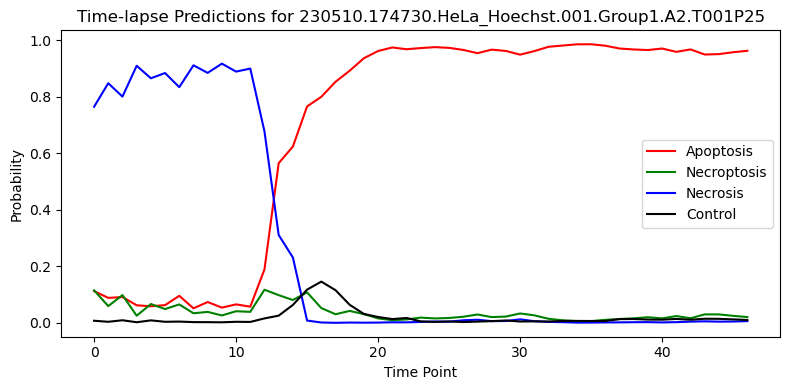

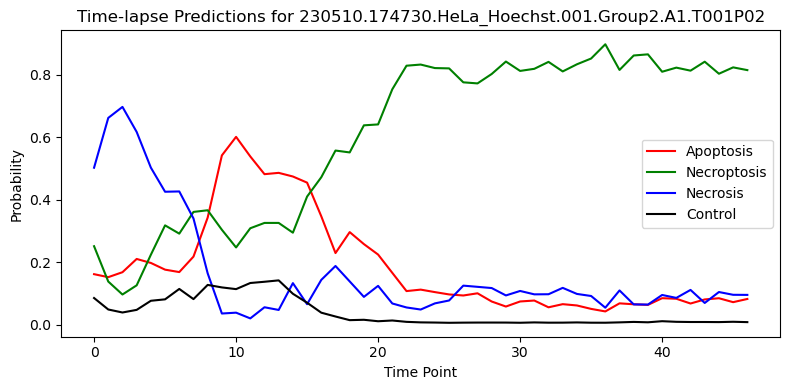

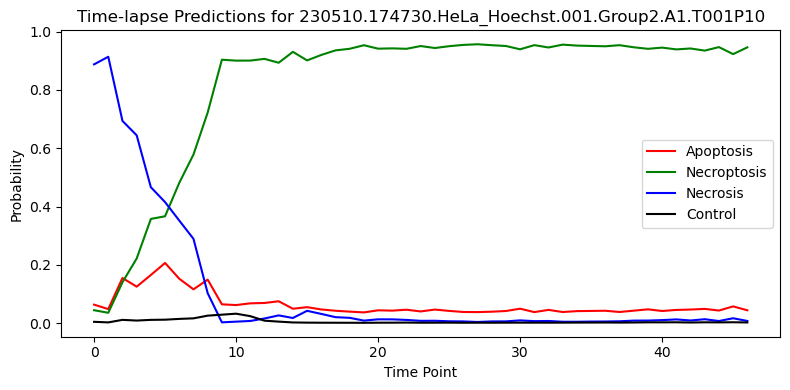

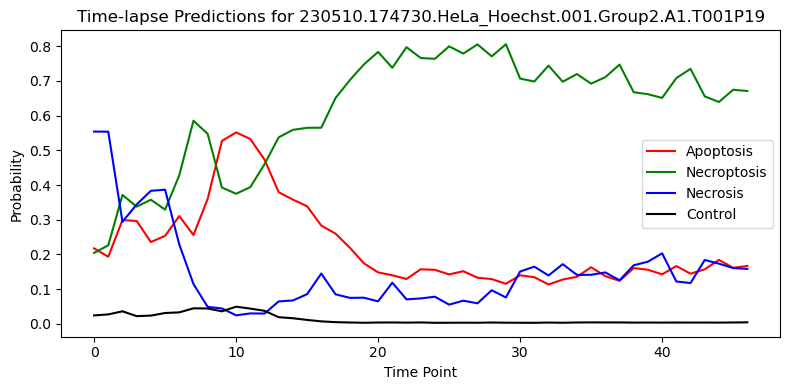

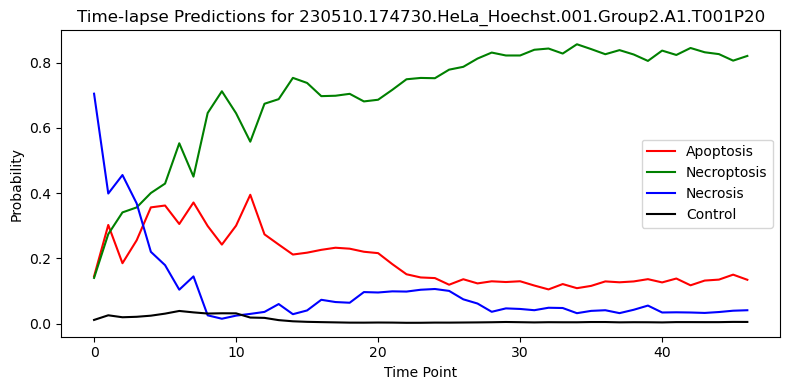

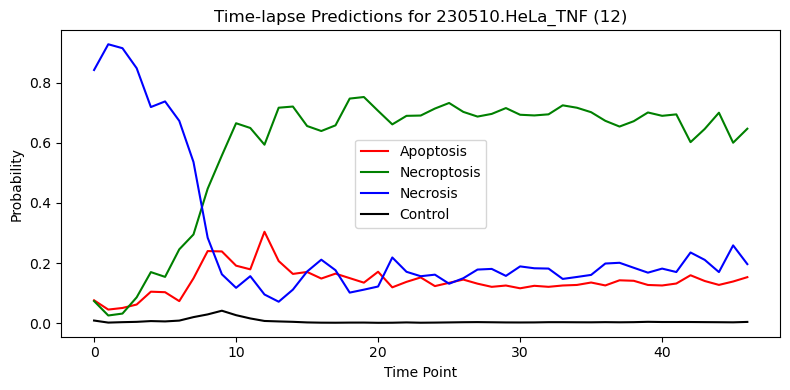

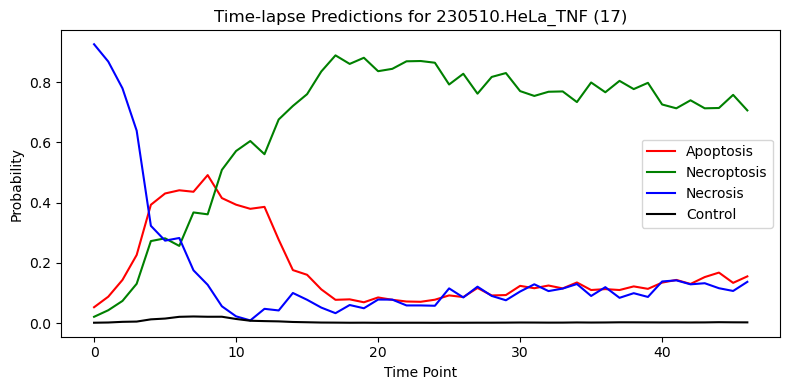

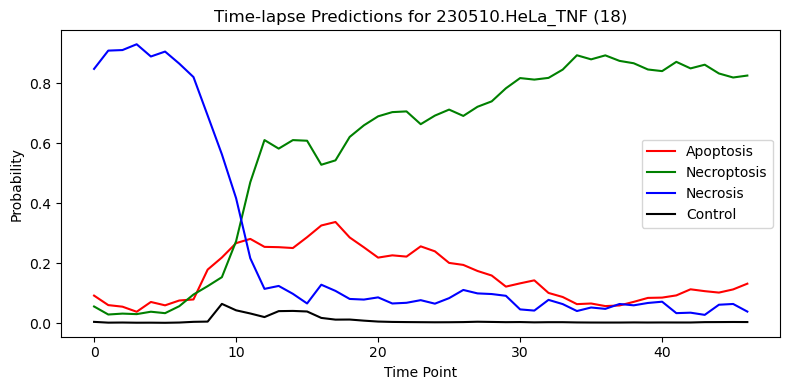

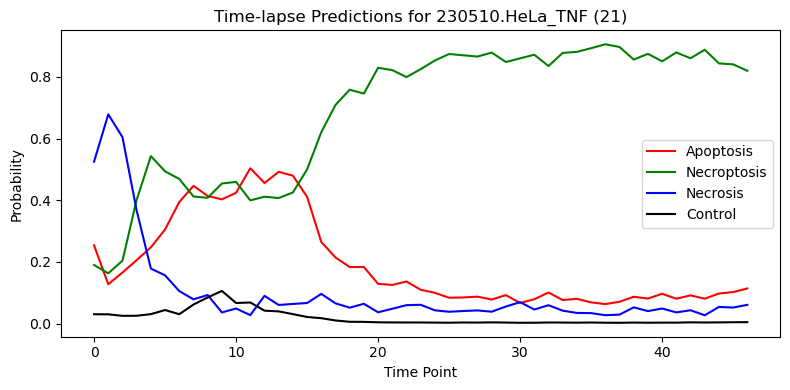

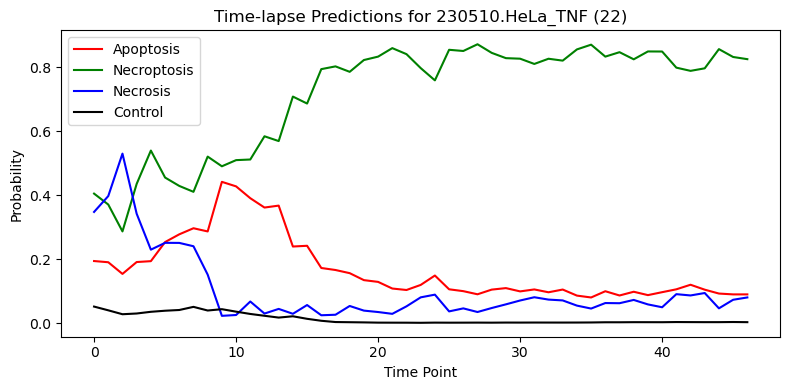

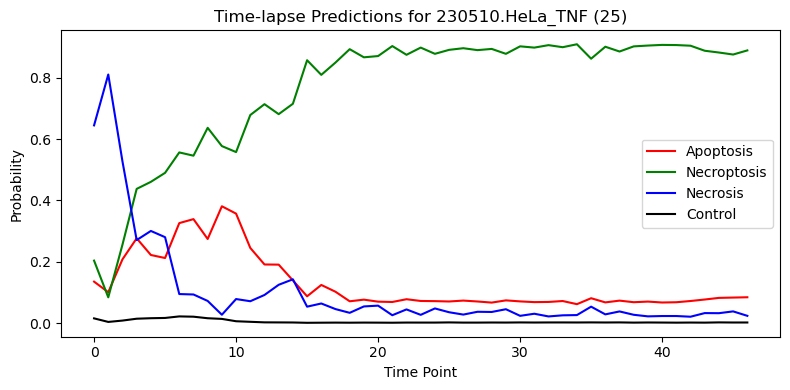

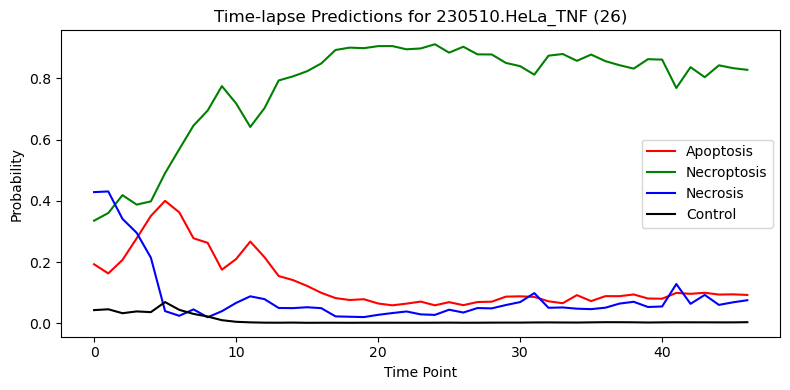

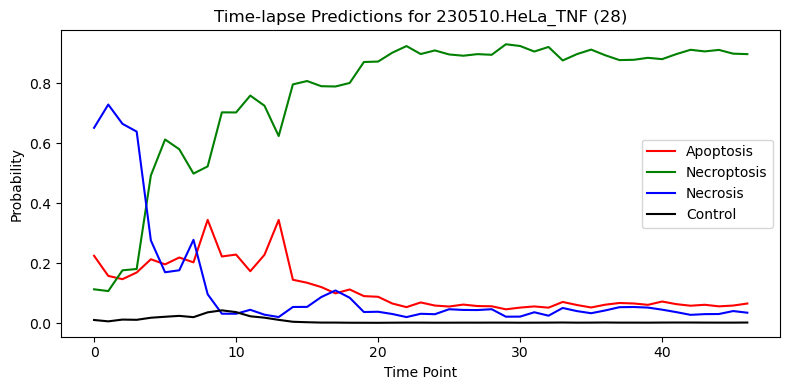

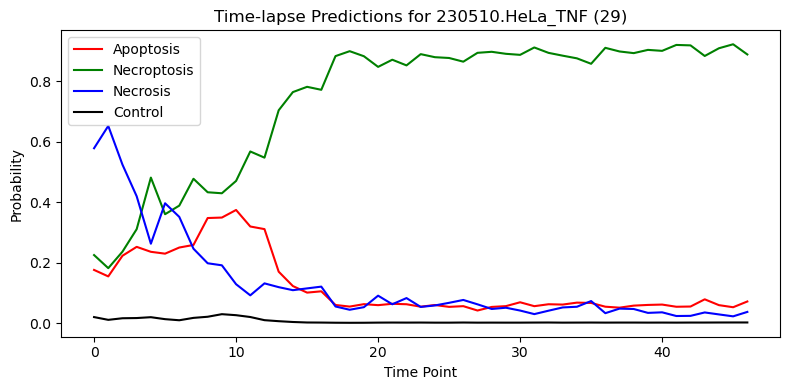

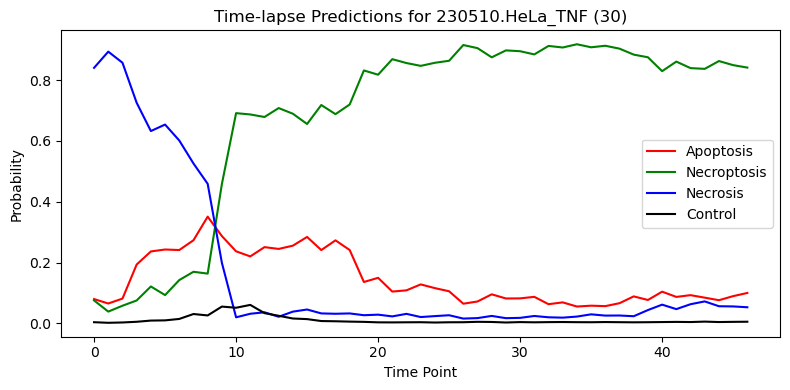

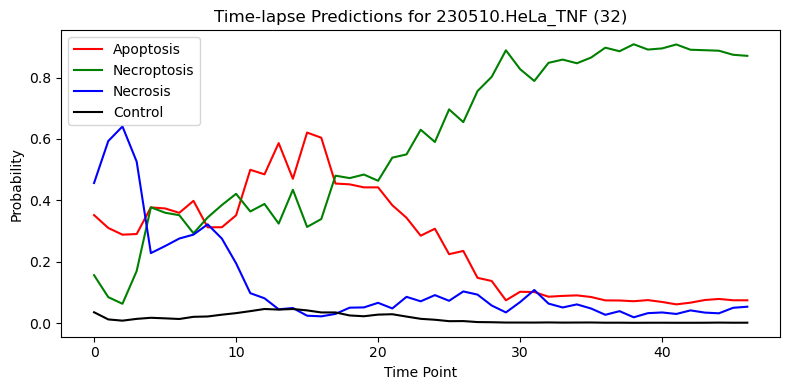

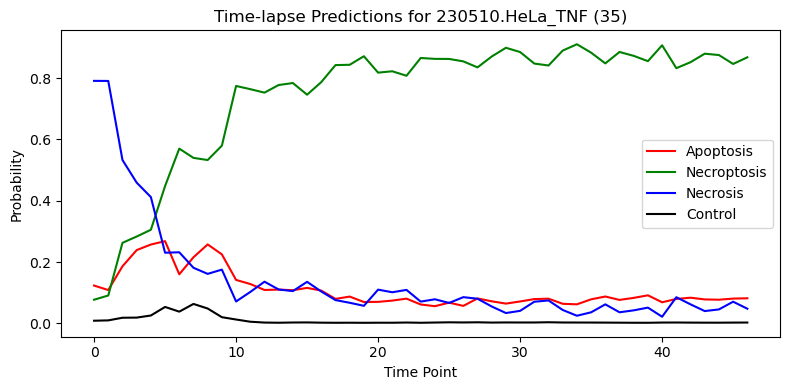

In [37]:
import os
import glob
import h5py
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from collections import defaultdict

# --- Settings and device ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = r"C:\rkka_Projects\cell_death_v2\Data\model_training_timelapse\train\0_Necroptosis"  # update with your folder
model_path = r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"

# --- Load and prepare model ---
model = torchvision.models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

# Use the standard transform from ResNet101 weights
transform = torchvision.models.ResNet101_Weights.IMAGENET1K_V2.transforms()

# --- Prediction function for one patch's time stack ---
def predict_time_series(stack, model, transform, device='cuda'):
    """
    Given a time-lapse stack (numpy array of shape [T, H, W]),
    return a dict of class probability time series.
    """
    probabilities = {}
    with torch.no_grad():
        probabilities['apoptosis'] = []
        probabilities['necroptosis'] = []
        probabilities['necrosis'] = []
        probabilities['control'] = []
        
        for s in stack:
            N = len(stack)
            
            s = torch.from_numpy(s).cuda()

            # Step 2 : Make RGB channel - C
            s = s.unsqueeze(0)
            s = s.repeat(3,1,1) # (C, H, W)
            s = transform(s)
            transformed_s.append(s)
    
            output = model(s.unsqueeze(0).cuda())
            output_prob = torch.nn.functional.softmax(output)
            
            probabilities['apoptosis'].append(float(output_prob[0][0].cpu()))
            probabilities['necroptosis'].append(float(output_prob[0][1].cpu()))
            probabilities['necrosis'].append(float(output_prob[0][2].cpu()))
            probabilities['control'].append(float(output_prob[0][3].cpu()))
    return probabilities

# --- Average predictions across patches for the same file ---
def average_patch_predictions(probs_list):
    """
    Given a list of dictionaries (one per patch) where each dict has lists
    of probabilities per time point, average them for each class.
    Assumes that each patch has the same number of time points.
    """
    num_patches = len(probs_list)
    T = len(probs_list[0]['apoptosis'])
    avg_probs = {'apoptosis': [], 'necroptosis': [], 'necrosis': [], 'control': []}
    
    for t in range(T):
        avg_probs['apoptosis'].append(np.mean([p['apoptosis'][t] for p in probs_list]))
        avg_probs['necroptosis'].append(np.mean([p['necroptosis'][t] for p in probs_list]))
        avg_probs['necrosis'].append(np.mean([p['necrosis'][t] for p in probs_list]))
        avg_probs['control'].append(np.mean([p['control'][t] for p in probs_list]))
    return avg_probs

# --- Load all h5 patch files and predict ---
# Assumes patch files are named like "filename_patch_0.h5", "filename_patch_1.h5", etc.
h5_files = glob.glob(os.path.join(data_dir, "*.h5"))
results = defaultdict(list)

for h5_file in h5_files:
    base_name = os.path.basename(h5_file)
    base_key = base_name.split('_patch_')[0]  # Group patches from the same original file
    
    with h5py.File(h5_file, 'r') as hf:
        # Assumes your h5 dataset is stored under the key 'data'
        stack = hf['data'][:]  # e.g., shape (T, H, W)
    
    patch_probs = predict_time_series(stack, model, transform, device=device)
    results[base_key].append(patch_probs)

# --- Average predictions per file and plot the time series ---
for base_key, probs_list in results.items():
    avg_probs = average_patch_predictions(probs_list)
    
    plt.figure(figsize=(8, 4))
    plt.plot(avg_probs['apoptosis'], 'r-', label='Apoptosis')
    plt.plot(avg_probs['necroptosis'], 'g-', label='Necroptosis')
    plt.plot(avg_probs['necrosis'], 'b-', label='Necrosis')
    plt.plot(avg_probs['control'], 'k-', label='Control')
    plt.xlabel("Time Point")
    plt.ylabel("Probability")
    plt.title(f"Time-lapse Predictions for {base_key}")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [7]:
stack.shape

(49, 480, 480)

In [28]:
with h5py.File(r"C:\rkka_Projects\cell_death_v2\Data\model_training_timelapse\train\0_Control\240820.114537.cell death_0820.001.Group1.A1.T001P01_patch_00.h5", 'r') as hf:
    stack = hf['data'][:]

In [29]:
import torchvision
import torch
model = torchvision.models.resnet101()
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 4)
)

model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_death_v2\epoch_5_2D_MIP_val_acc_1.0000.pth"))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20396\1749555092.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:\rkka_Projects\cell_deat

<All keys matched successfully>

In [ ]:
import torchvision 

model = model.cuda()
model.eval()

min_ri = 1.33
max_ri = 1.40

transform = torchvision.models.ResNet101_Weights.IMAGENET1K_V2.transforms()
transformed_s = []

probabilities = {}
with torch.no_grad():
    probabilities['apotosis'] = []
    probabilities['necroptosis'] = []
    probabilities['necrosis'] = []
    probabilities['control'] = []
    
    for s in stack:
        N = len(stack)
        death_probability = 0
        output_list = []
        
        s = torch.from_numpy(s).cuda()

        # Step 2 : Make RGB channel - C
        s = s.unsqueeze(0)
        s = s.repeat(3,1,1) # (C, H, W)
        s = transform(s)
        transformed_s.append(s)
 
        output = model(s.unsqueeze(0).cuda())
        output_prob = torch.nn.functional.softmax(output)
        
        probabilities['apotosis'].append(float(output_prob[0][0].cpu()))
        probabilities['necroptosis'].append(float(output_prob[0][1].cpu()))
        probabilities['necrosis'].append(float(output_prob[0][2].cpu()))
        probabilities['control'].append(float(output_prob[0][3].cpu()))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_20396\3799975897.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output_prob = torch.nn.functional.softmax(output)


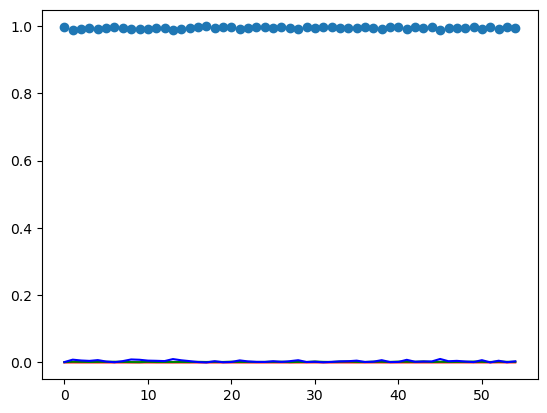

In [31]:
import matplotlib.pyplot as plt

plt.plot(apoptosis_prob, 'r')
plt.plot(necroptosis_prob, 'g')
plt.plot(necrosis_prob, 'b')
plt.plot(live_prob, 'o')

In [18]:
stack.shape

(47, 480, 480)